In [1]:
import sys
sys.path.append("../")
import os
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns
import matplotlib.pyplot as plt

from coh_tools import *

from sklearn.decomposition import PCA
import math

In [2]:


repo_dir = "/home/julien/lab/opto_data_analysis"
data_dir = "/media/julien/easystore/lab/elife/data"
only_paired=False
skip_short=False
scale_PCA=False
skip_single_stim=True

experiments = pd.read_csv(repo_dir+'/csvs/table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]

multiband_allcon_dict = pkl.load(open(data_dir+"/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_allcon_phase_dict = pkl.load(open(data_dir+"/pickled/multiband_timefreq_allcon_phase_dict.pkl", "rb"))

ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = repo_dir+"/csvs/")

m1_data = pd.read_csv(repo_dir+'/csvs/M1_sites.csv')
s1_data = pd.read_csv(repo_dir+'/csvs/S1_sites.csv')

def get_distance(electrode_a, electrode_b): # Indexing is 1 - 96
    if min(electrode_a, electrode_b) <= 0:
#         print("Electrode indexing starts from 1")
#         return
        return 0
    return ((ecog_map[0][electrode_a-1]  - ecog_map[0][electrode_b-1])**2 + (ecog_map[1][electrode_a-1]  - ecog_map[1][electrode_b-1])**2)**.5

# Flattens same way as np flatten()
def get_distances_multi(electrode_list_a, electrode_list_b=[]):
    electrode_list_b = np.array(electrode_list_b).astype(int)
    electrode_list_a = np.array(electrode_list_a).astype(int)
    if not electrode_list_b.any():
        electrode_list_b = electrode_list_a
    distances = []
    for electrode_a in electrode_list_a:
        for electrode_b in electrode_list_b:
            distances.append(get_distance(electrode_a, electrode_b))
    return distances

good_channels = pkl.load(open(repo_dir+"/pickled/good_channels.pkl", "rb"))


In [3]:
get_cond = False

In [4]:

## Generate dataframe
dataframes = {}
for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)

    data_dict = multiband_allcon_dict[band]
    phase_dict = multiband_allcon_phase_dict[band]
    from_electrodes = []
    to_electrodes = []
    stim_froms = []
    stim_tos = []
    phasemeans = []

    condmeans = []
    basemeans = []
    newbasemeans = []
    cond_sds = []
    base_sds = []

    coh_cov_elec = []
    coh_cov_time = []

    delays = []
    deltacohs = []
    distances = []
    num_lasers = []
    coherence_projections = []
    coherence_projections_sd = []

    coherence_diff_mag = []
    coherence_diff_mag_sd = []
    coherence_sum_mag = []
    coherence_sum_mag_sd = []

    avg_pair_net_coh = []
    avg_pair_net_coh_sd = []
    avg_graph_net_coh = []
    avg_graph_net_coh_sd = []

    block_nums = []
    distances_to_a1 = []
    distances_to_b1 = []
    distances_to_a2 = []
    distances_to_b2 = []
    experiment_block_keys = []
    pc1a_mean = []
    pc2a_mean = []
    pc1b_mean = []
    pc2b_mean = []
    pc1a_sd = []
    pc2a_sd = []
    pc1b_sd = []
    pc2b_sd = []
    monkeys = []
    both_m1 = []
    both_s1 = []
    in_upper_triangle = []
    on_diagonal = []
    
    end_diff = []

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])

        if exp_num_laser != 0:# and key not in ["MonkeyG_20150918_Session1_M1", "MonkeyG_20150918_Session1_S1"]:
            continue
        else:
            print(key)

        exp_good_channels = good_channels[key[:-3]]
        distancelist = get_distances_multi(exp_good_channels)
        from_electrode_list = np.tile(np.array(exp_good_channels), [len(exp_good_channels),1]).T.flatten()
        to_electrode_list = np.tile(np.array(exp_good_channels), [len(exp_good_channels),1]).flatten()
        stim_from_list = (np.ones((len(exp_good_channels), len(exp_good_channels)))*row["stim_Coh_from"]).flatten()
        stim_to_list = (np.ones((len(exp_good_channels), len(exp_good_channels)))*row["stim_Coh_to"]).flatten()
        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
        distance_to_a1_list = get_distances_multi(exp_good_channels, a_list)
        distance_to_b1_list = get_distances_multi(exp_good_channels, b_list)
        distance_to_a2_list = get_distances_multi(a_list, exp_good_channels)
        distance_to_b2_list = get_distances_multi(b_list, exp_good_channels)
        monkey_list = [key[6]]*len(distancelist)
        exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser
        m1_exp_data, s1_exp_data = get_m1_s1_matrices(m1_data, s1_data, good_channels, key[:-3])
        on_diagonal_list = np.eye(len(exp_good_channels)).flatten()
        in_upper_triangle_list = np.triu(np.ones(len(exp_good_channels)), 1).flatten()

        try:
            exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
        except:
            exp_delay_list = np.zeros(len(distancelist))

        for block_num in np.arange(6)+1:
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            
            if get_cond:
                rec_key = stim_key
            
            if block_num < 6:
                block_base_data = data_dict[rec_key]
                block_base_data_means = block_base_data.mean(0)

                if skip_short:
                    if block_base_data.shape[0] == 1:
                        break
                        
                end_diff.append(data_dict[key+"_RecBlock6"].mean(0).flatten() - block_base_data_means.flatten())

                basemeans.append(block_base_data_means.flatten())
                phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                condmeans.append(data_dict[stim_key].mean(0).flatten())


                base_sds.append(block_base_data.std(0).flatten())
                cond_sds.append(data_dict[stim_key].std(0).flatten())

                coherence_projections.append(np.asarray([np.dot(base_data, base_data) for base_data in block_base_data]).mean(0).flatten()/block_base_data_means.shape[0])
                coherence_projections_sd.append(np.asarray([np.dot(base_data, base_data) for base_data in block_base_data]).std(0).flatten())

###
                coh_cov_elec.append(np.asarray([np.cov(block) for block in block_base_data]).mean(0).flatten())
                coh_cov_time.append(np.asarray([np.cov(block_base_data[:,:,elec].T) for elec in range(block_base_data.shape[-1])]).mean(0).flatten())

                coherence_diff_mag.append(np.asarray([get_coh_diff_mag(base_data) for base_data in block_base_data]).mean(0).flatten())
                coherence_sum_mag.append(np.asarray([get_coh_sum_mag(base_data) for base_data in block_base_data]).mean(0).flatten())

                coherence_diff_mag_sd.append(np.asarray([get_coh_diff_mag(base_data) for base_data in block_base_data]).std(0).flatten())
                coherence_sum_mag_sd.append(np.asarray([get_coh_sum_mag(base_data) for base_data in block_base_data]).std(0).flatten())

                avg_pair_net_coh.append(get_pair_net_coh(block_base_data_means).flatten())
                avg_pair_net_coh_sd.append(np.asarray([get_pair_net_coh(base_data) for base_data in block_base_data]).std(0).flatten())
                avg_graph_net_coh.append(block_base_data_means.mean()*np.ones(len(distancelist)))
                avg_graph_net_coh_sd.append(block_base_data.mean(1).mean(1).std()*np.ones(len(distancelist)))

                distances.append(distancelist)
                distances_to_a1.append(distance_to_a1_list)
                distances_to_b1.append(distance_to_b1_list)
                distances_to_a2.append(distance_to_a2_list)
                distances_to_b2.append(distance_to_b2_list)
                num_lasers.append(exp_num_laser_list)
                delays.append(exp_delay_list)
                block_nums.append(block_num*np.ones(len(distancelist)))
                experiment_block_keys.append([stim_key[:-11]]*len(distancelist))
                both_m1.append(m1_exp_data.flatten())
                both_s1.append(s1_exp_data.flatten())
                stim_froms.append(stim_from_list)
                stim_tos.append(stim_to_list)
                from_electrodes.append(from_electrode_list)
                to_electrodes.append(to_electrode_list)

                on_diagonal.append(on_diagonal_list)
                in_upper_triangle.append(in_upper_triangle_list)

                if block_num == 1:
                    scaler = StandardScaler(with_std=scale_PCA)
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)

                pca_mean_data = pca.transform(scaler.transform(block_base_data_means)) # * block_base_data_means.shape[0] # how to normalize this across different numelec?
                pca_sd_data = np.asarray([pca.transform(scaler.transform(sd_vec)) for sd_vec in block_base_data]).std(0)

                pc1a_mean.append(np.repeat(pca_mean_data[:, 0], pca_mean_data.shape[0]))
                pc2a_mean.append(np.repeat(pca_mean_data[:, 1], pca_mean_data.shape[0]))
                pc1b_mean.append(np.tile(pca_mean_data[:, 0], pca_mean_data.shape[0]))
                pc2b_mean.append(np.tile(pca_mean_data[:, 1], pca_mean_data.shape[0]))

                pc1a_sd.append(np.repeat(pca_sd_data[:, 0], pca_sd_data.shape[0]))
                pc2a_sd.append(np.repeat(pca_sd_data[:, 1], pca_sd_data.shape[0]))
                pc1b_sd.append(np.tile(pca_sd_data[:, 0], pca_sd_data.shape[0]))
                pc2b_sd.append(np.tile(pca_sd_data[:, 1], pca_sd_data.shape[0]))

#                 experiment_keys.append([key]*)
                monkeys.append(monkey_list)

            if (block_num > 1) and (get_cond == False):
                newbasemeans.append(data_dict[rec_key].mean(0).flatten())

    phasemeans = np.asarray(np.concatenate(phasemeans)).flatten()
    distances = np.asarray(np.concatenate(distances)).flatten()
    distances_to_a1 = np.asarray(np.concatenate(distances_to_a1)).flatten()
    distances_to_b1 = np.asarray(np.concatenate(distances_to_b1)).flatten()
    distances_to_a2 = np.asarray(np.concatenate(distances_to_a2)).flatten()
    distances_to_b2 = np.asarray(np.concatenate(distances_to_b2)).flatten()
    basemeans = np.asarray(np.concatenate(basemeans)).flatten()
    if not get_cond:
        newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
    condmeans = np.asarray(np.concatenate(condmeans)).flatten()

    base_sds = np.asarray(np.concatenate(base_sds)).flatten()
    cond_sds = np.asarray(np.concatenate(cond_sds)).flatten()

    num_lasers = np.asarray(np.concatenate(num_lasers)).flatten()
    coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
    coherence_projections_sd = np.asarray(np.concatenate(coherence_projections_sd)).flatten()

    coherence_diff_mag = np.asarray(np.concatenate(coherence_diff_mag)).flatten()
    coherence_sum_mag = np.asarray(np.concatenate(coherence_sum_mag)).flatten()

    coherence_diff_mag_sd = np.asarray(np.concatenate(coherence_diff_mag_sd)).flatten()
    coherence_sum_mag_sd = np.asarray(np.concatenate(coherence_sum_mag_sd)).flatten()

    delays = np.asarray(np.concatenate(delays)).flatten()
    block_nums = np.asarray(np.concatenate(block_nums)).flatten()
    pc1a_mean = np.asarray(np.concatenate(pc1a_mean)).flatten()
    pc2a_mean = np.asarray(np.concatenate(pc2a_mean)).flatten()
    pc1b_mean = np.asarray(np.concatenate(pc1b_mean)).flatten()
    pc2b_mean = np.asarray(np.concatenate(pc2b_mean)).flatten()

    pc1a_sd = np.asarray(np.concatenate(pc1a_sd)).flatten()
    pc2a_sd = np.asarray(np.concatenate(pc2a_sd)).flatten()
    pc1b_sd = np.asarray(np.concatenate(pc1b_sd)).flatten()
    pc2b_sd = np.asarray(np.concatenate(pc2b_sd)).flatten()

    on_diagonal = np.asarray(np.concatenate(on_diagonal)).flatten()
    in_upper_triangle = np.asarray(np.concatenate(in_upper_triangle)).flatten()

    monkeys = np.asarray(np.concatenate(monkeys)).flatten()
    experiment_block_keys = np.asarray(np.concatenate(experiment_block_keys)).flatten()
    both_m1 = np.asarray(np.concatenate(both_m1)).flatten()
    both_s1 = np.asarray(np.concatenate(both_s1)).flatten()
    from_electrodes = np.asarray(np.concatenate(from_electrodes)).flatten()
    to_electrodes = np.asarray(np.concatenate(to_electrodes)).flatten()
    stim_froms = np.asarray(np.concatenate(stim_froms)).flatten()
    stim_tos = np.asarray(np.concatenate(stim_tos)).flatten()

    avg_pair_net_coh = np.asarray(np.concatenate(avg_pair_net_coh)).flatten()
    avg_pair_net_coh_sd = np.asarray(np.concatenate(avg_pair_net_coh_sd)).flatten()
    avg_graph_net_coh = np.asarray(np.concatenate(avg_graph_net_coh)).flatten()
    avg_graph_net_coh_sd = np.asarray(np.concatenate(avg_graph_net_coh_sd)).flatten()

    coh_cov_elec = np.asarray(np.concatenate(coh_cov_elec)).flatten()
    coh_cov_time = np.asarray(np.concatenate(coh_cov_time)).flatten()

    end_diff = np.asarray(np.concatenate(end_diff)).flatten()
    
    cond_diff_Y = condmeans - basemeans
    cond_diff_percent_Y = (condmeans - basemeans)/basemeans
    
    if not get_cond:
        diff_Y = newbasemeans - basemeans
        diff_percent_Y = (newbasemeans - basemeans)/basemeans

    data = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
                        "Coh_proj": coherence_projections, "Coh_proj_sd": coherence_projections_sd, "Phase": phasemeans,
                        "Distance_to_A1": distances_to_a1, "Distance_to_B1": distances_to_b1,
                        "Distance_to_A2": distances_to_a2, "Distance_to_B2": distances_to_b2,
                        "PC1a_mean": pc1a_mean, "PC2a_mean": pc2a_mean, "PC1b_mean": pc1b_mean, "PC2b_mean": pc2b_mean,
                        "PC1a_sd": pc1a_sd, "PC2a_sd": pc2a_sd, "PC1b_sd": pc1b_sd, "PC2b_sd": pc2b_sd,
                        "From_electrodes": from_electrodes, "To_electrodes": to_electrodes,
                        "Stim_froms": stim_froms, "Stim_tos": stim_tos,
                        "Initial_coh_sd": base_sds, "Cond_coh_sd": cond_sds,
                        "Coh_diff_sd": coherence_diff_mag_sd, "Coh_sum_sd": coherence_sum_mag_sd,
                        "Coh_diff_mag": coherence_diff_mag,
                        "Coh_sum_mag": coherence_sum_mag, "On_diagonal": on_diagonal,
                        "In_upper_triangle": in_upper_triangle,
                        "Pair_avg_net_coh": avg_pair_net_coh, "Pair_avg_net_coh_sd": avg_pair_net_coh_sd,
                        "Graph_avg_net_coh": avg_graph_net_coh, "Graph_avg_net_coh_sd": avg_graph_net_coh_sd,
                        "Elec_cov": coh_cov_elec, "Time_cov": coh_cov_time, "End_diff": end_diff})        
    data["Num_lasers"] = num_lasers
    data["Delays"] = delays
    data["Distance_to_A1"] = distances_to_a1
    data["Distance_to_B1"] = distances_to_b1
    data["Distance_to_A2"] = distances_to_a2
    data["Distance_to_B2"] = distances_to_b2

    data["Monkeys"] = monkeys
    data["Block_num"] = block_nums
    data["Experiment_block_key"] = experiment_block_keys
    data["Both_M1"] = both_m1
    data["Both_S1"] = both_s1

    data["cond_diff_Y"] = cond_diff_Y  
    data["cond_diff_percent_Y"] = cond_diff_percent_Y
    if not get_cond:
        data["diff_Y"] = diff_Y
        data["diff_percent_Y"] = diff_percent_Y

    data["Is_stim_site_1"] = np.where(data["From_electrodes"] == data["Stim_froms"], 1, 0)
    data["Is_stim_site_2"] = np.where(data["To_electrodes"] == data["Stim_tos"], 1, 0)

    if only_paired:
            data = data.loc[(data["Stim_froms"] == data["From_electrodes"]) & (data["Stim_tos"] == data["To_electrodes"])]
            data = data.drop(['Distance_to_A1',
   'Distance_to_B1', 'Distance_to_A2', 'Distance_to_B2'], axis=1)

    # data = data.drop(["Stim_froms", "Stim_tos", "From_electrodes", "To_electrodes"], axis=1)
    data = data.drop(["Stim_froms", "Stim_tos"], axis=1)

    dataframes[band] = data

    del(data)

theta
MonkeyG_20150911_Session2_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyG_20150911_Session5_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyJ_20160624_Session2_S1
MonkeyJ_20160625_Session2_S1
beta
MonkeyG_20150911_Session2_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyG_20150911_Session5_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyJ_20160624_Session2_S1
MonkeyJ_20160625_Session2_S1
gamma
MonkeyG_20150911_Session2_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyG_20150911_Session5_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyJ_20160624_Session2_S1
MonkeyJ_20160625_Session2_S1
high_gamma
MonkeyG_20150911_Session2_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyG_20150911_Session5_S1


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel

MonkeyJ_20160624_Session2_S1
MonkeyJ_20160625_Session2_S1


In [6]:
dataframes["theta"].head()

Initial_coh  Distance  Coh_proj  Coh_proj_sd     Phase  Distance_to_A1  \
0     1.000000  0.000000  0.169128          0.0  0.000000       13.038405   
1     0.363210  1.000000  0.089534          0.0  0.066915       13.038405   
2     0.228915  3.000000  0.137770          0.0  0.375838       13.038405   
3     0.833435  1.000000  0.172139          0.0  0.067986       13.038405   
4     0.237438  1.414214  0.140034          0.0  0.393582       13.038405   

   Distance_to_B1  Distance_to_A2  Distance_to_B2  PC1a_mean  ...  Block_num  \
0             6.0       13.038405        6.000000   1.186209  ...        1.0   
1             6.0       12.206556        6.082763   1.186209  ...        1.0   
2             6.0       10.630146        6.708204   1.186209  ...        1.0   
3             6.0       12.529964        5.000000   1.186209  ...        1.0   
4             6.0       11.661904        5.099020   1.186209  ...        1.0   

           Experiment_block_key  Both_M1  Both_S1  cond_diff_Y  \
0  MonkeyG_20150911_Session2_S1      1.0      0.0     0.000000   
1  MonkeyG_20150911_Session2_S1      1.0      0.0    -0.118600   
2  MonkeyG_20150911_Session2_S1      1.0      0.0     0.009626   
3  MonkeyG_20150911_Session2_S1      1.0      0.0     0.022774   
4  MonkeyG_20150911_Session2_S1      1.0      0.0     0.003534   

   cond_diff_percent_Y    diff_Y  diff_percent_Y  Is_stim_site_1  \
0             0.000000  0.000000        0.000000               0   
1            -0.326534  0.058144        0.160083               0   
2             0.042051 -0.044293       -0.193490               0   
3             0.027326 -0.056113       -0.067328               0   
4             0.014883 -0.022169       -0.093369               0   

   Is_stim_site_2  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 47 columns]

In [10]:
dataframes["theta"][dataframes["theta"]["Experiment_block_key"].isnull()]

Empty DataFrame
Columns: [Initial_coh, Distance, Coh_proj, Coh_proj_sd, Phase, PC1a_mean, PC2a_mean, PC1b_mean, PC2b_mean, PC1a_sd, PC2a_sd, PC1b_sd, PC2b_sd, From_electrodes, To_electrodes, Initial_coh_sd, Cond_coh_sd, Coh_diff_sd, Coh_sum_sd, Coh_diff_mag, Coh_sum_mag, Pair_avg_net_coh, Pair_avg_net_coh_sd, Graph_avg_net_coh, Graph_avg_net_coh_sd, Elec_cov, Time_cov, End_diff, Monkeys, Block_num, Experiment_block_key, Both_M1, Both_S1, cond_diff_Y, cond_diff_percent_Y, diff_Y, diff_percent_Y, Is_stim_site_1, Is_stim_site_2]
Index: []

[0 rows x 39 columns]

In [6]:
dataframes["theta"].columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
       'Distance_to_A1', 'Distance_to_B1', 'Distance_to_A2', 'Distance_to_B2',
       'PC1a_mean', 'PC2a_mean', 'PC1b_mean', 'PC2b_mean', 'PC1a_sd',
       'PC2a_sd', 'PC1b_sd', 'PC2b_sd', 'From_electrodes', 'To_electrodes',
       'Initial_coh_sd', 'Cond_coh_sd', 'Coh_diff_sd', 'Coh_sum_sd',
       'Coh_diff_mag', 'Coh_sum_mag', 'On_diagonal', 'In_upper_triangle',
       'Pair_avg_net_coh', 'Pair_avg_net_coh_sd', 'Graph_avg_net_coh',
       'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov', 'End_diff',
       'Num_lasers', 'Delays', 'Monkeys', 'Block_num', 'Experiment_block_key',
       'Both_M1', 'Both_S1', 'cond_diff_Y', 'cond_diff_percent_Y', 'diff_Y',
       'diff_percent_Y', 'Is_stim_site_1', 'Is_stim_site_2'],
      dtype='object')

In [9]:
for band in dataframes.keys():
    dataframes[band] = dataframes[band][dataframes[band]["In_upper_triangle"] == 1]
    dataframes[band] = dataframes[band].drop(columns=["On_diagonal", "In_upper_triangle", "Num_lasers"])
    dataframes[band] = dataframes[band].drop(columns=['Distance_to_A1', 'Distance_to_B1', 'Distance_to_A2', 'Distance_to_B2', "Delays"])

In [11]:
dataframes["theta"]["Experiment_block_key"].unique()

array(['MonkeyG_20150911_Session2_S1', 'MonkeyG_20150911_Session5_S1',
       'MonkeyJ_20160624_Session2_S1', 'MonkeyJ_20160625_Session2_S1'],
      dtype=object)

In [12]:
dataframes["theta"].columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
       'PC1a_mean', 'PC2a_mean', 'PC1b_mean', 'PC2b_mean', 'PC1a_sd',
       'PC2a_sd', 'PC1b_sd', 'PC2b_sd', 'From_electrodes', 'To_electrodes',
       'Initial_coh_sd', 'Cond_coh_sd', 'Coh_diff_sd', 'Coh_sum_sd',
       'Coh_diff_mag', 'Coh_sum_mag', 'Pair_avg_net_coh',
       'Pair_avg_net_coh_sd', 'Graph_avg_net_coh', 'Graph_avg_net_coh_sd',
       'Elec_cov', 'Time_cov', 'End_diff', 'Monkeys', 'Block_num',
       'Experiment_block_key', 'Both_M1', 'Both_S1', 'cond_diff_Y',
       'cond_diff_percent_Y', 'diff_Y', 'diff_percent_Y', 'Is_stim_site_1',
       'Is_stim_site_2'],
      dtype='object')

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
dataframes["theta"].head()

Initial_coh  Distance  Coh_proj  Coh_proj_sd     Phase  PC1a_mean  \
1     0.363210  1.000000  0.089534          0.0  0.066915   1.186209   
2     0.228915  3.000000  0.137770          0.0  0.375838   1.186209   
3     0.833435  1.000000  0.172139          0.0  0.067986   1.186209   
4     0.237438  1.414214  0.140034          0.0  0.393582   1.186209   
5     0.178304  3.162278  0.121423          0.0  0.373202   1.186209   

   PC2a_mean  PC1b_mean  PC2b_mean  PC1a_sd  PC2a_sd  PC1b_sd  PC2b_sd  \
1   0.520331   3.099708  -0.286800      0.0      0.0      0.0      0.0   
2   0.520331   1.682723   0.577647      0.0      0.0      0.0      0.0   
3   0.520331   1.065264   0.522827      0.0      0.0      0.0      0.0   
4   0.520331   1.625968   0.597559      0.0      0.0      0.0      0.0   
5   0.520331   1.907625   0.211202      0.0      0.0      0.0      0.0   

   From_electrodes  To_electrodes  Initial_coh_sd  Cond_coh_sd  Coh_diff_sd  \
1                1              2             0.0     0.118351          0.0   
2                1              4             0.0     0.098768          0.0   
3                1              5             0.0     0.079903          0.0   
4                1              6             0.0     0.098906          0.0   
5                1              8             0.0     0.092041          0.0   

   Coh_sum_sd  Coh_diff_mag  Coh_sum_mag  Pair_avg_net_coh  \
1         0.0      0.227845     0.651307          0.575193   
2         0.0      0.143527     0.781824          0.722471   
3         0.0      0.018161     0.830400          0.750934   
4         0.0      0.137995     0.786307          0.726822   
5         0.0      0.163736     0.746204          0.693902   

   Pair_avg_net_coh_sd  Graph_avg_net_coh  Graph_avg_net_coh_sd  Elec_cov  \
1                  0.0           0.440332                   0.0  0.013950   
2                  0.0           0.440332                   0.0  0.007461   
3                  0.0           0.440332                   0.0  0.031545   
4                  0.0           0.440332                   0.0  0.008119   
5                  0.0           0.440332                   0.0  0.001648   

   Time_cov  End_diff Monkeys  Block_num          Experiment_block_key  \
1       NaN  0.146849       G        1.0  MonkeyG_20150911_Session2_S1   
2       NaN  0.041261       G        1.0  MonkeyG_20150911_Session2_S1   
3       NaN -0.083380       G        1.0  MonkeyG_20150911_Session2_S1   
4       NaN  0.040921       G        1.0  MonkeyG_20150911_Session2_S1   
5       NaN  0.056180       G        1.0  MonkeyG_20150911_Session2_S1   

   Both_M1  Both_S1  cond_diff_Y  cond_diff_percent_Y    diff_Y  \
1      1.0      0.0    -0.118600            -0.326534  0.058144   
2      1.0      0.0     0.009626             0.042051 -0.044293   
3      1.0      0.0     0.022774             0.027326 -0.056113   
4      1.0      0.0     0.003534             0.014883 -0.022169   
5      1.0      0.0     0.015925             0.089311 -0.049865   

   diff_percent_Y  Is_stim_site_1  Is_stim_site_2  
1        0.160083               0               0  
2       -0.193490               0               0  
3       -0.067328               0               0  
4       -0.093369               0               0  
5       -0.279665               0               0

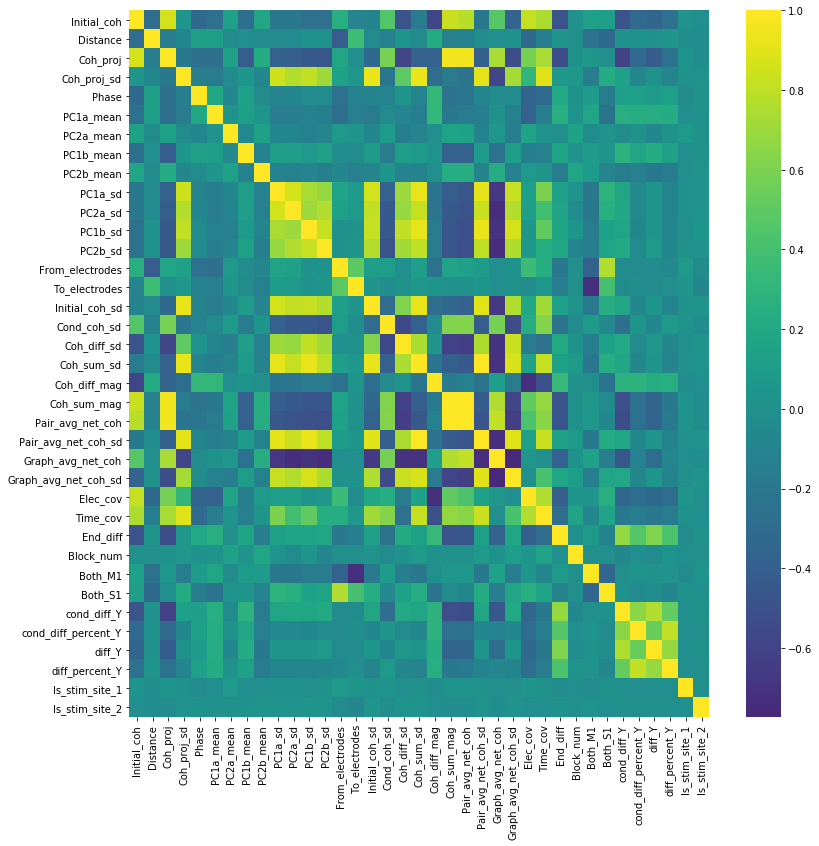

In [15]:
plt.figure(figsize=(13, 13))
sns.heatmap(dataframes["theta"].corr(), cmap="viridis", center=0)

In [16]:
for band in ["theta", "beta", "gamma", "high_gamma"]:
    #dataframes[band].rename(columns={"Coh_diff_mag": "Coh_diff_avg"}, inplace=True)
    dataframes[band] = dataframes[band].drop(columns = ['Coh_sum_mag', 'Coh_sum_sd', 'PC1a_mean', 'PC2a_mean', 'PC1b_mean', 
                                                        'PC2b_mean', 'PC1a_sd', 'PC2a_sd', 'PC1b_sd', 'PC2b_sd',
                                                       'Cond_coh_sd'])

In [17]:
# if during-stim data

#for band in ["theta", "beta", "gamma", "high_gamma"]:    
#    dataframes[band] = dataframes[band].drop(columns = ['cond_diff_Y', 'cond_diff_percent_Y'])

In [18]:
dataframes["theta"].columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Coh_proj_sd', 'Phase',
       'From_electrodes', 'To_electrodes', 'Initial_coh_sd', 'Coh_diff_sd',
       'Coh_diff_mag', 'Pair_avg_net_coh', 'Pair_avg_net_coh_sd',
       'Graph_avg_net_coh', 'Graph_avg_net_coh_sd', 'Elec_cov', 'Time_cov',
       'End_diff', 'Monkeys', 'Block_num', 'Experiment_block_key', 'Both_M1',
       'Both_S1', 'cond_diff_Y', 'cond_diff_percent_Y', 'diff_Y',
       'diff_percent_Y', 'Is_stim_site_1', 'Is_stim_site_2'],
      dtype='object')

In [19]:
pkl.dump(dataframes, open("/home/julien/lab/data/opto_data/processed_control_optodata_withshort_21jul20.pkl", "wb"))